# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader, Subset

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback

from models.conditional_flow_matching import TransferCFM
from models.utils import plot_trajectories

vector.register_awkward()

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|----------------------

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 100000
   ... sample: 100000
   ... tree: 100000
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi
  

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        # 'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 39842 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([39842, 2, 5]), mask ([39842, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 39842.00, 39842.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : False
Zs         : data ([39842, 2, 5]), mask ([39842, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 39842.00, 39842.00
             Features 

Before preprocessing


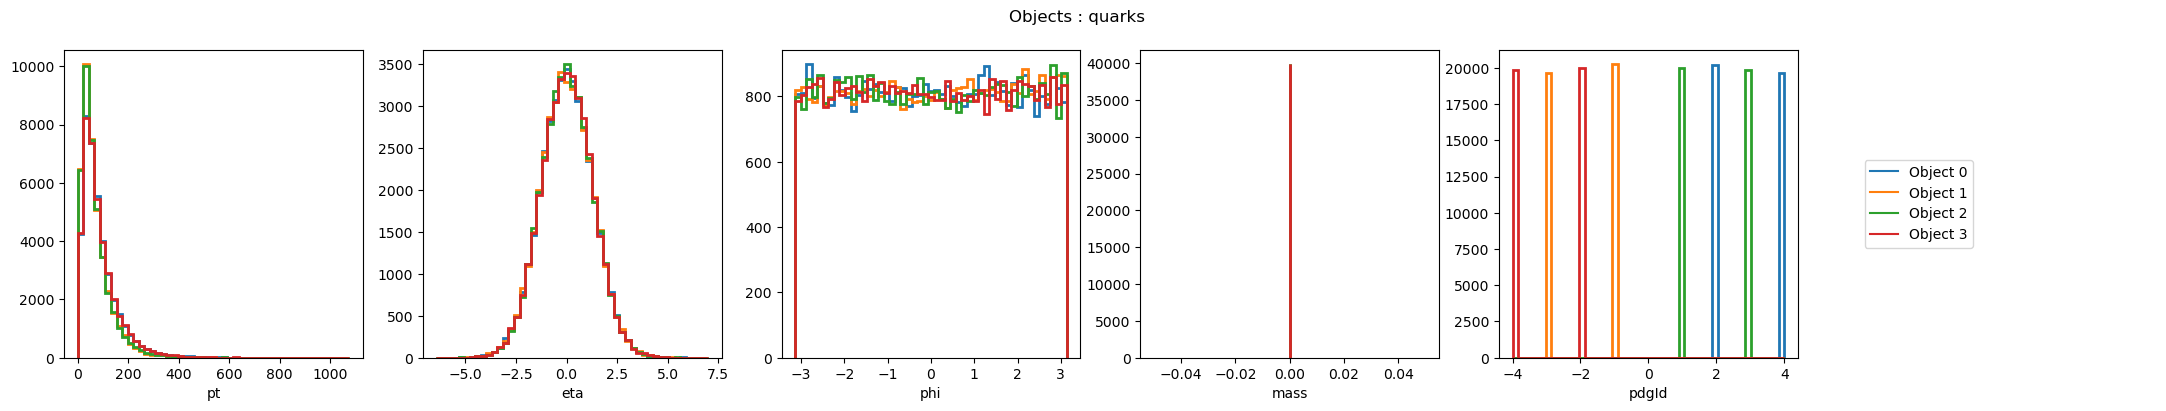

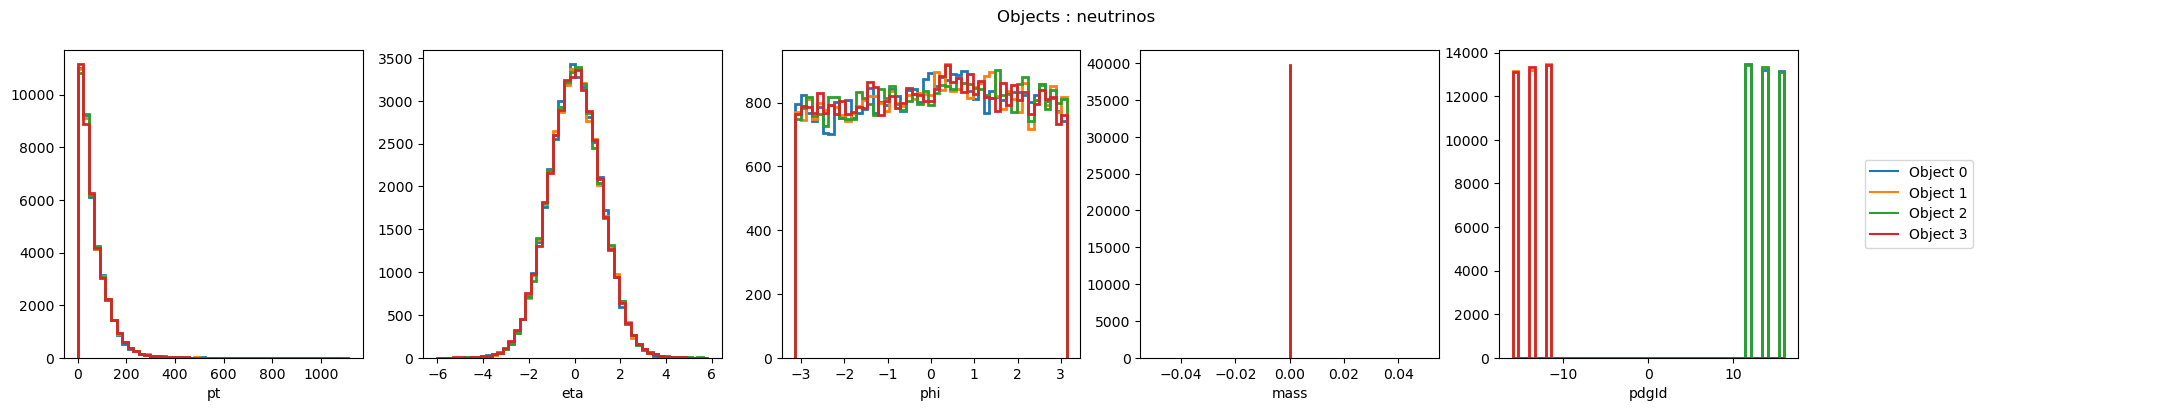

After preprocessing


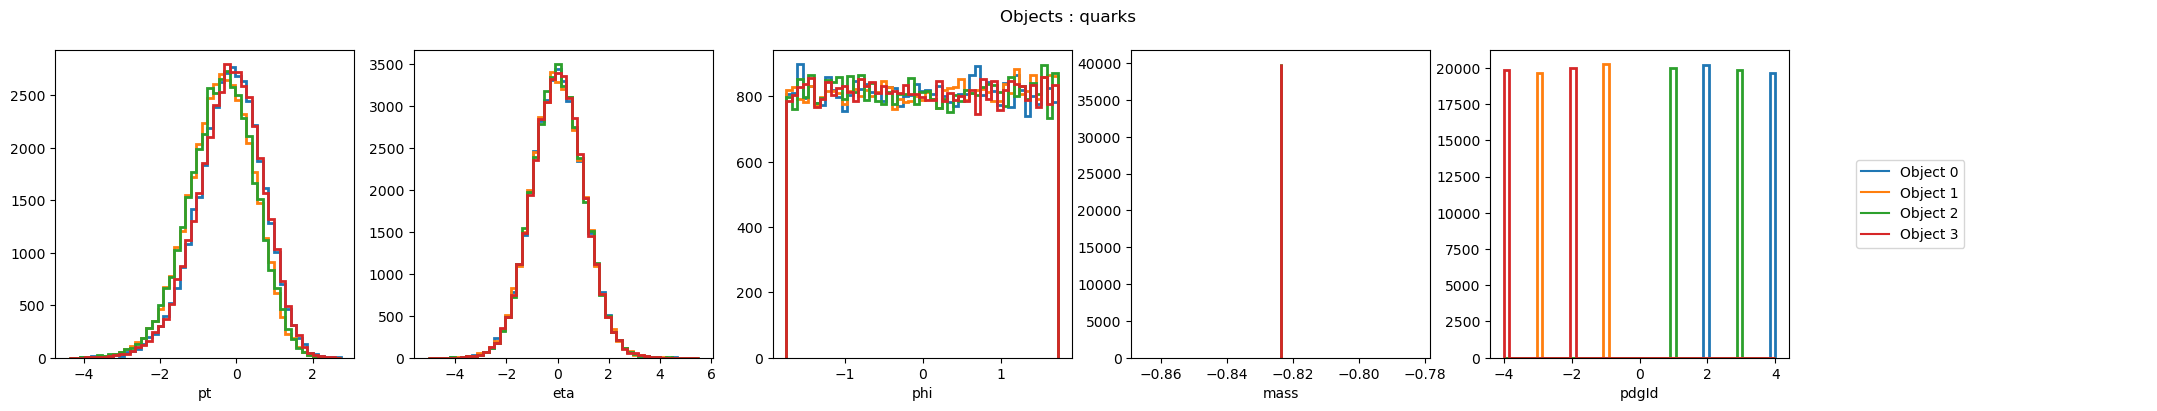

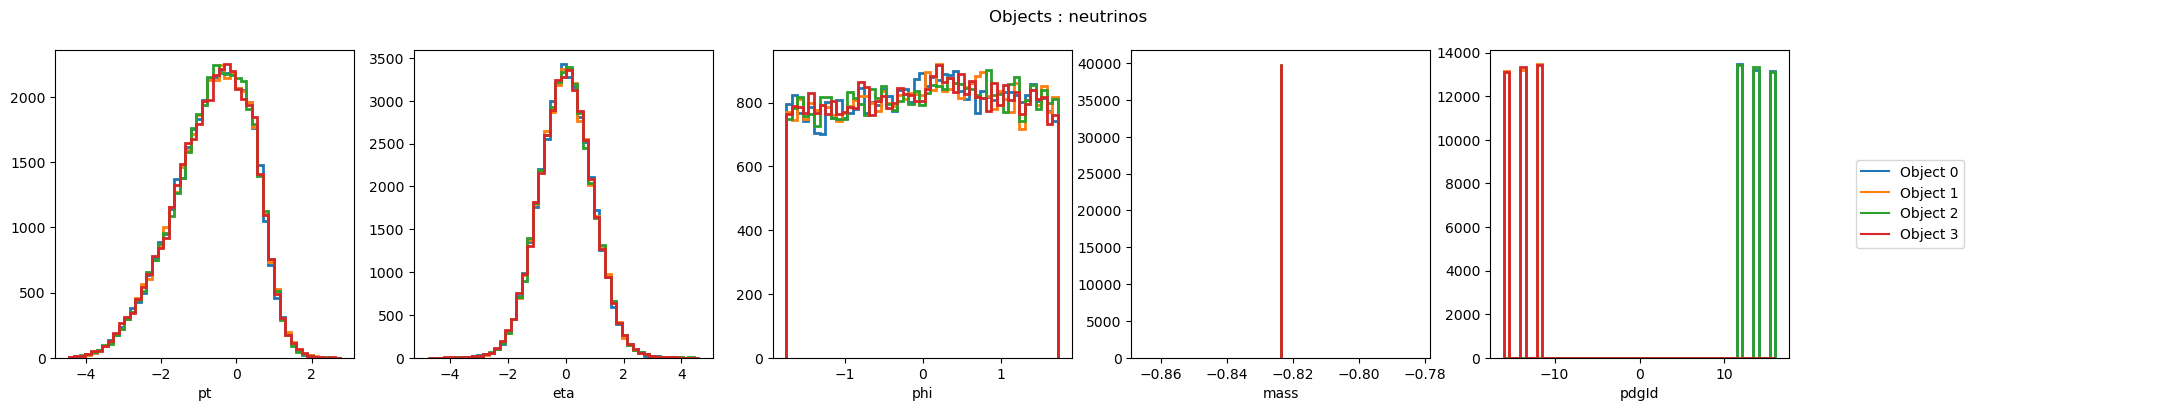

In [4]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

In [5]:
# This is not strictly necessary, but just to make sure loading works as expected
# We will use later a combined dataset (hard+reco) below
hard_loader = DataLoader(
    hard_dataset,
    batch_size = 32,
)
batch = next(iter(hard_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],hard_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

quarks torch.Size([32, 4, 5]) torch.Size([32, 4])
neutrinos torch.Size([32, 4, 5]) torch.Size([32, 4])


# Reco dataset

In [6]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    N = data_hard.N,
)

print (data_reco)

Data object
Loaded branches:
   ... file: 100000
   ... sample: 100000
   ... tree: 100000
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


In [7]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 49446 events
Containing the following tensors
jets  : data ([49446, 15, 5]), mask ([49446, 15])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
        Mask attn     : [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
        Weights       : 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'b

Before preprocessing


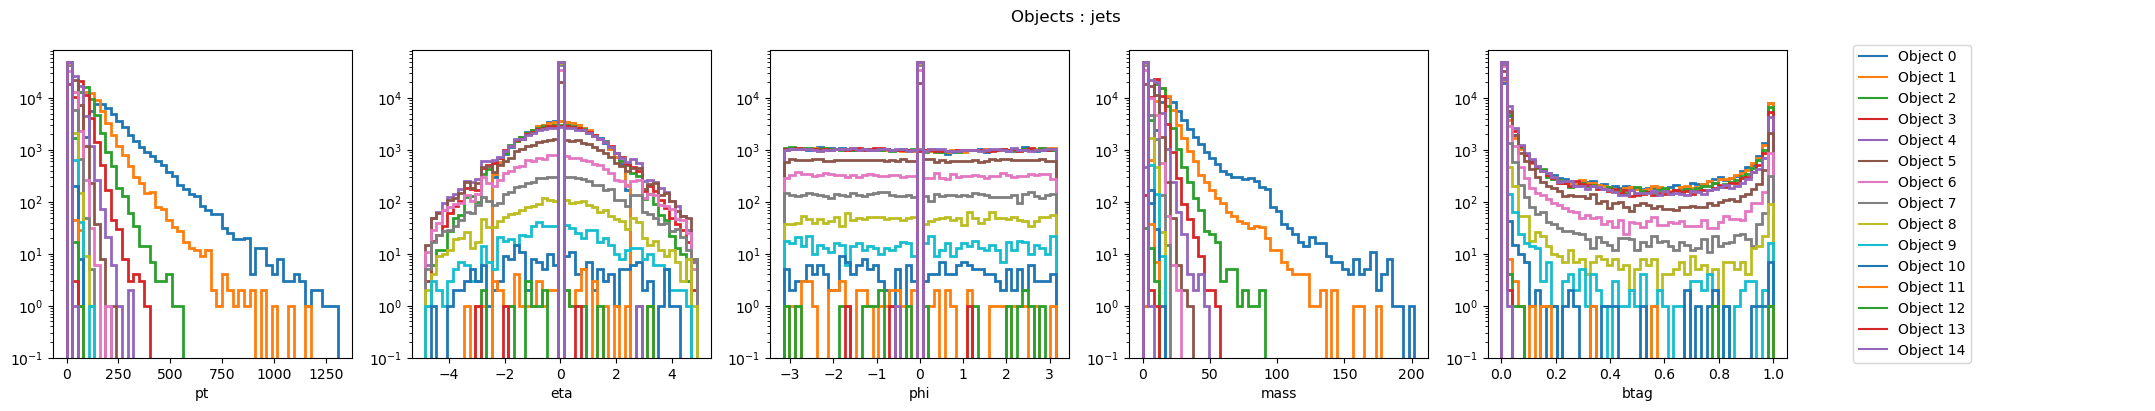

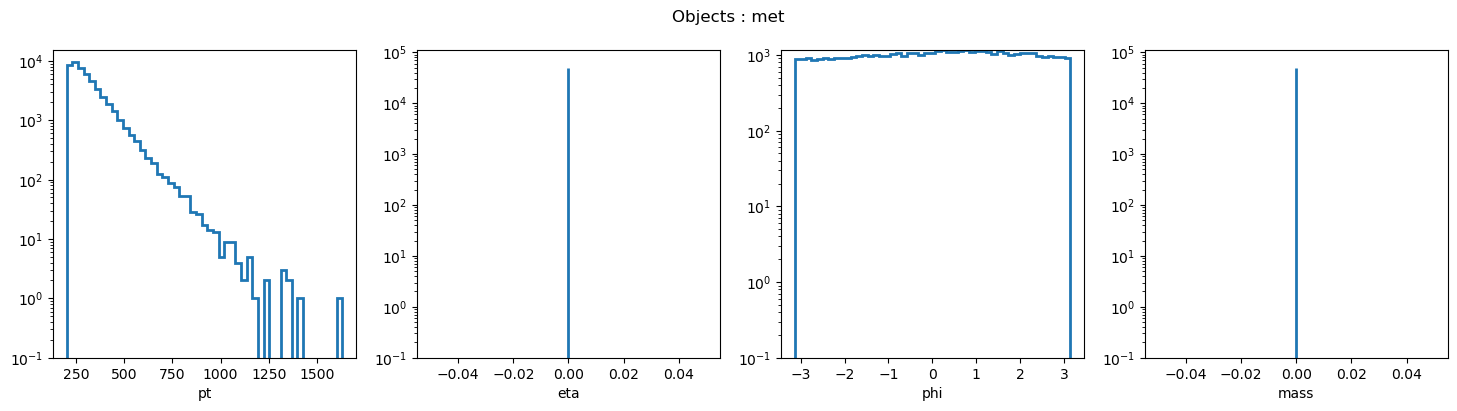

After preprocessing


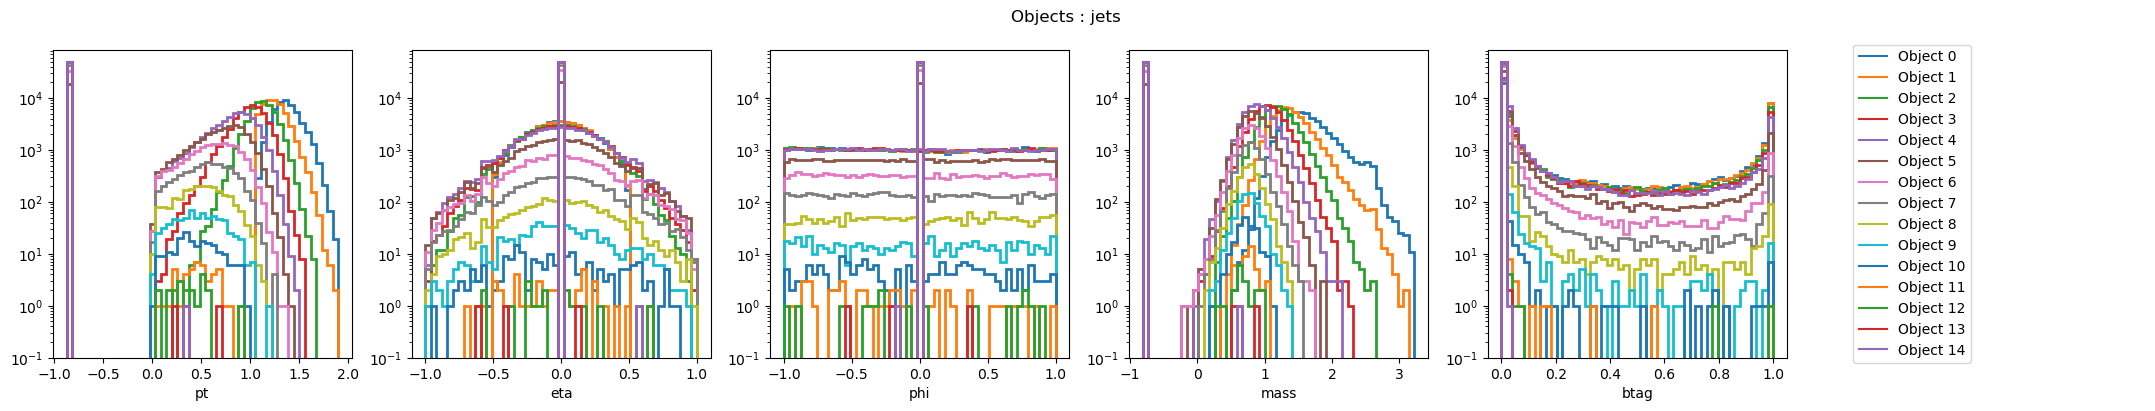

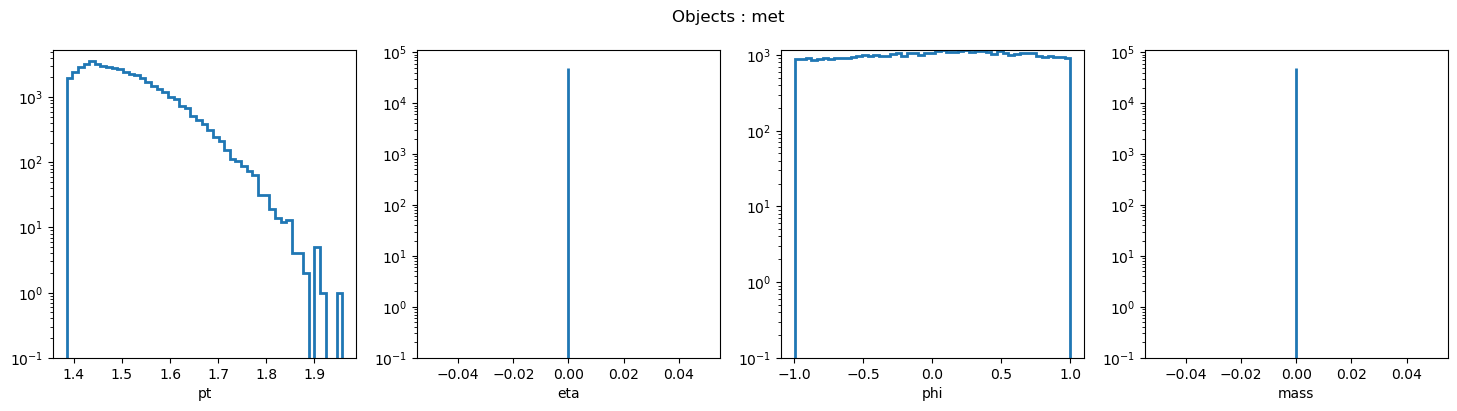

In [8]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [9]:
# Also not needed, just checking 
reco_loader = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(reco_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],reco_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

jets torch.Size([32, 15, 5]) torch.Size([32, 15])
met torch.Size([32, 1, 4]) torch.Size([32, 1])


# Combined dataset

In [10]:
print(f'Intersection Branch: {reco_dataset.intersection_branch}')
print (f'Hard Datset keys: {hard_dataset.metadata.keys()}')
print (f'Reco Datset keys: {reco_dataset.metadata.keys()}')

combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection Branch: event
Hard Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Reco Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 39842 events, 4828 selected
For entry 1 : from 49446 events, 4828 selected
Combined dataset (extracting 4828 events of the following) :
Parton dataset with 39842 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([39842, 2, 5]), mask ([39842, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]


In [11]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size = 256,
)
batch = next(iter(combined_loader))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],combined_loader.dataset.reco_dataset.selection):
    print (sel,obj.shape,mask.shape)

print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],combined_loader.dataset.hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
jets torch.Size([256, 15, 5]) torch.Size([256, 15])
met torch.Size([256, 1, 4]) torch.Size([256, 1])
Hard
quarks torch.Size([256, 4, 5]) torch.Size([256, 4])
neutrinos torch.Size([256, 4, 5]) torch.Size([256, 4])


In [12]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

combined_dataset_train = torch.utils.data.Subset(combined_dataset,train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

combined_loader_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
combined_loader_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(combined_loader_train)} / Validation {len(combined_loader_valid)}')

Dataset : training 3862 / validation 966
Batching 4 / Validation 1


# Transfer flow

In [13]:
print(combined_dataset.hard_dataset.input_features) # Determine the available features that you can select in ` flow_input_features`
# Note the length of this (2 elements) must match the length of  `flow_input_features`
# But you dont have to select all the features in each element
print(combined_dataset.reco_dataset.input_features)

(('pt', 'eta', 'phi', 'mass', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'))
(('pt', 'eta', 'phi', 'mass', 'btag'), ('pt', 'eta', 'phi', 'mass'))


In [17]:
#from models.conditional_flow_matching import TransferCFM

cfm_model = TransferCFM(
    embed_dims=[64, 64],
    embed_act=nn.GELU(),
    n_hard_particles_per_type=hard_dataset.number_particles_per_type,
    hard_particle_type_names=hard_dataset.selection,
    hard_input_features_per_type=hard_dataset.input_features,
    n_reco_particles_per_type=reco_dataset.number_particles_per_type,
    reco_particle_type_names=reco_dataset.selection,
    reco_input_features_per_type=reco_dataset.input_features,
    flow_input_features=[
        ['pt','eta'],#,'phi'],  # for jets
        ['pt','phi'],        # for met
    ],
    reco_mask_attn=reco_dataset.attention_mask,
    hard_mask_attn=None,   # or your own if needed
    dropout=0.0,
    transformer_args={
        "nhead": 8,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 128,
        "activation": 'gelu',
    },
    sigma=0.1,
)

# 2) Set up the trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    # ...
)

# 3) Fit
trainer.fit(
    model=cfm_model,
    train_dataloaders=combined_loader_train,
    val_dataloaders=combined_loader_valid,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name            | Type        | Params | Mode 
--------------------------------------------------------
0 | embed_act       | GELU        | 0      | train
1 | hard_embeddings | ModuleList  | 9.1 K  | train
2 | reco_embeddings | ModuleList  | 9.0 K  | train
3 | transformer     | Transformer | 335 K  | train
4 | vel_head        | Sequential  | 26.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.518     Total estimated model params size (MB)
124       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 1

In [15]:
# # # Preprocess the dataset to include only the first 2 jets
# # print(combined_dataset_valid.keys())
# # print(type(combined_dataset_valid['reco']))
# # print(combined_dataset_valid['reco'])
# # # Limit to the first 2 jets in the 'data' key
# # for i, tensor in enumerate(combined_dataset_valid['reco']['data']):
# #     combined_dataset_valid['reco']['data'][i] = tensor[:2]  # Keep only the first 2 jets
# # print(combined_dataset_valid['reco']['data'])
# # MODIFY EVENTS IN CLASS WHEN SELECTING EVENTS (EG EVENTS THAT HAVE 1 B JET OR 5 JETS, ORDER IN BTAG OR PT)

# # Callbacks to make plots within comet
# bias = BiasCallback(
#     dataset = combined_dataset_valid,               # dataset on which to evaluate bias
#     preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
#     N_sample = 100,                                 # number of samples to draw
#     frequency = 20,                                 # plotting frequency (epochs)
#     raw = True,
#     bins = 101,                                      # 1D/2D plot number of bins
#     points = 20,                                    # Number of points for the quantile
#     log_scale = True,                               # log
#     batch_size = 50000,                              # Batch size to evaluate the dataset (internally makes a loaded)
#     N_batch = 1,                                   # Stop after N batches (makes it faster)
#     suffix = 'ttH',                                 # name for plots
#     label_names = {                                 # makes nicer labels
#         'pt' : 'p_T',
#         'eta' : '\eta',
#         'phi' : '\phi',
#     },
#     device=accelerator,  # Explicitly set the device
# )
# figs = bias.make_bias_plots(model,show=True) # show is to plot standalone 
# # of course now they are bad, need to train first

In [16]:
# sampling = SamplingCallback(
#     dataset = combined_dataset_valid,           # dataset to check sampling
#     preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
#     idx_to_monitor = [0,2,],               # idx of events in dataset to make plots with
#     N_sample = 100000,                         # number of samples to draw
#     frequency = 10,                             # plotting frequency (epochs)
#     bins = 51,                                  # 1D/2D plot number of bins
#     log_scale = True,                           # log
#     label_names = {                             # makes nicer labels
#         'pt' : 'p_T',
#         'eta' : '\eta',
#         'phi' : '\phi',
#     },
# )
# figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

In [ ]:
print(type(batch['hard']['data']), len(batch['hard']['data'])) # len = 2 is for 2 particles
print(type(batch['reco']['data']), len(batch['reco']['data']))

print(batch['hard']['data']) # shape [batch_size, num_particles, num_features]

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    cfm_model._optimizer,
    mode="min",
    factor=0.1,
    patience=5,
    threshold=0.001,
    min_lr=1e-7,
)
cfm_model._scheduler_config = {
    "scheduler": scheduler,
    "interval": "epoch",
    "frequency": 1,
    "monitor": "val_loss",
    "strict": True,
    "name": "lr_scheduler",
}

# Minimal trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1 if accelerator=="cuda" else None,
    # log_every_n_steps=...
)

trainer.fit(
    model=cfm_model,
    train_dataloaders=combined_loader_train,
    val_dataloaders=combined_loader_valid,
)

In [ ]:
# If you want to do validation:
trainer.validate(
    model=cfm_model,
    dataloaders=combined_loader_valid
)

# If you want to save the model:
torch.save(cfm_model.state_dict(), "my_cfm_model.pt")

In [ ]:
figs = sampling.make_sampling_plots(model.cuda(),show=True) # show is to plot standalone 

In [ ]:
figs = bias.make_bias_plots(model.cuda(),show=True) # show is to plot standalone 